## **In this notebook, I will construct an LSTM model and develop a basic strategy using the prediction results. I will also analyze the drawdown.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [89]:
df = pd.read_csv('/kaggle/input/nifty50-stock-market-data/ADANIPORTS.csv')
df = df.set_index('Date').drop(['Symbol','Series'], axis=1).dropna()

**Since this dataset only contains price and volume data, I will start by establishing commonly used price indicators**

In [34]:
def create_feature(df):
    df['factor_overnight_OHLCV_t0'] = df['Open'].shift(-1) / df['Close'] - 1
    df['factor_HL_OHLCV'] = df['High']/df['Low'] - 1
    df['factor_HO_OHLCV'] = df['High']/df['Open'] - 1
    df['factor_LO_OHLCV'] = df['Low']/df['Open'] - 1
    df['factor_CH_OHLCV'] = df['Close']/df['High'] - 1
    df['factor_CL_OHLCV'] = df['Close']/df['Low'] - 1
    df['factor_daily'] = df['Close'].shift(-1)/df['Open'].shift(-1) - 1
    df['factor_turnover_OHLCV'] = df['Volume']/df['Trades']
    df['factor_amihud_highLow_OHLCV'] = (df['factor_HL_OHLCV'] * 1000000)/df['Volume']
    df['Close_t-1'] = df['Close'].shift(1)
    df['factor_daily_OHLCV'] = df['Close']/df['Close_t-1'] - 1
    df['factor_amihud_OHLCV'] = (df['factor_daily_OHLCV'] * 1000000).abs()/df['Volume']
    df['factor_size_OHLCV'] = df['Trades'] * df['Close']

    # GH max
    df['factor_GH_min_250_OHLCV'] = df['Low'].rolling(250).min()/df['Close'] - 1
    df['factor_GH_min_120_OHLCV'] = df['Low'].rolling(120).min()/df['Close'] - 1
    df['factor_GH_min_90_OHLCV'] = df['Low'].rolling(90).min()/df['Close'] - 1
    df['factor_GH_min_60_OHLCV'] = df['Low'].rolling(60).min()/df['Close'] - 1
    df['factor_GH_min_20_OHLCV'] = df['Low'].rolling(20).min()/df['Close'] - 1
    df['factor_GH_min_10_OHLCV'] = df['Low'].rolling(10).min()/df['Close'] - 1
    df['factor_GH_min_5_OHLCV'] = df['Low'].rolling(5).min()/df['Close'] - 1

    # GH min
    df['factor_GH_max_250_OHLCV'] = df['High'].rolling(250).max()/df['Close'] - 1
    df['factor_GH_max_120_OHLCV'] = df['High'].rolling(120).max()/df['Close'] - 1
    df['factor_GH_max_90_OHLCV'] = df['High'].rolling(90).max()/df['Close'] - 1
    df['factor_GH_max_60_OHLCV'] = df['High'].rolling(60).max()/df['Close'] - 1
    df['factor_GH_max_20_OHLCV'] = df['High'].rolling(20).max()/df['Close'] - 1
    df['factor_GH_max_10_OHLCV'] = df['High'].rolling(10).max()/df['Close'] - 1
    df['factor_GH_max_5_OHLCV'] = df['High'].rolling(5).max()/df['Close'] - 1

    # mean
    df['factor_return_mean_250_OHLCV'] = df['factor_daily_OHLCV'].rolling(250).mean()
    df['factor_return_mean_120_OHLCV'] = df['factor_daily_OHLCV'].rolling(120).mean()
    df['factor_return_mean_90_OHLCV'] = df['factor_daily_OHLCV'].rolling(90).mean()
    df['factor_return_mean_60_OHLCV'] = df['factor_daily_OHLCV'].rolling(60).mean()
    df['factor_return_mean_20_OHLCV'] = df['factor_daily_OHLCV'].rolling(20).mean()
    df['factor_return_mean_10_OHLCV'] = df['factor_daily_OHLCV'].rolling(10).mean()
    df['factor_return_mean_5_OHLCV'] = df['factor_daily_OHLCV'].rolling(5).mean()

    # vola
    df['factor_return_std_250_OHLCV'] = df['factor_daily_OHLCV'].rolling(250).std()
    df['factor_return_std_120_OHLCV'] = df['factor_daily_OHLCV'].rolling(120).std()
    df['factor_return_std_90_OHLCV'] = df['factor_daily_OHLCV'].rolling(90).std()
    df['factor_return_std_60_OHLCV'] = df['factor_daily_OHLCV'].rolling(60).std()
    df['factor_return_std_20_OHLCV'] = df['factor_daily_OHLCV'].rolling(20).std()
    df['factor_return_std_10_OHLCV'] = df['factor_daily_OHLCV'].rolling(10).std()
    df['factor_return_std_5_OHLCV'] = df['factor_daily_OHLCV'].rolling(5).std()

    # skew
    df['factor_return_skew_250_OHLCV'] = df['factor_daily_OHLCV'].rolling(250).skew()
    df['factor_return_skew_120_OHLCV'] = df['factor_daily_OHLCV'].rolling(120).skew()
    df['factor_return_skew_90_OHLCV'] = df['factor_daily_OHLCV'].rolling(90).skew()
    df['factor_return_skew_60_OHLCV'] = df['factor_daily_OHLCV'].rolling(60).skew()
    df['factor_return_skew_20_OHLCV'] = df['factor_daily_OHLCV'].rolling(20).skew()
    df['factor_return_skew_10_OHLCV'] = df['factor_daily_OHLCV'].rolling(10).skew()
    df['factor_return_skew_5_OHLCV'] = df['factor_daily_OHLCV'].rolling(5).skew()

    # kurt
    df['factor_return_kurt_250_OHLCV'] = df['factor_daily_OHLCV'].rolling(250).kurt()
    df['factor_return_kurt_120_OHLCV'] = df['factor_daily_OHLCV'].rolling(120).kurt()
    df['factor_return_kurt_90_OHLCV'] = df['factor_daily_OHLCV'].rolling(90).kurt()
    df['factor_return_kurt_60_OHLCV'] = df['factor_daily_OHLCV'].rolling(60).kurt()
    df['factor_return_kurt_20_OHLCV'] = df['factor_daily_OHLCV'].rolling(20).kurt()
    df['factor_return_kurt_10_OHLCV'] = df['factor_daily_OHLCV'].rolling(10).kurt()
    df['factor_return_kurt_5_OHLCV'] = df['factor_daily_OHLCV'].rolling(5).kurt()

    # abnormal volume
    df['factor_abnormal_volume_250_OHLCV'] = df['Volume']/df['Volume'].rolling(250).mean() - 1
    df['factor_abnormal_volume_120_OHLCV'] = df['Volume']/df['Volume'].rolling(120).mean() - 1
    df['factor_abnormal_volume_90_OHLCV'] = df['Volume']/df['Volume'].rolling(90).mean() - 1
    df['factor_abnormal_volume_60_OHLCV'] = df['Volume']/df['Volume'].rolling(60).mean() - 1
    df['factor_abnormal_volume_20_OHLCV'] = df['Volume']/df['Volume'].rolling(20).mean() - 1
    df['factor_abnormal_volume_10_OHLCV'] = df['Volume']/df['Volume'].rolling(10).mean() - 1
    df['factor_abnormal_volume_5_OHLCV'] = df['Volume']/df['Volume'].rolling(5).mean() - 1


    # abnormal HL
    df['factor_abnormal_HL_250_OHLCV'] = df['factor_HL_OHLCV']/df['factor_HL_OHLCV'].rolling(250).mean() - 1
    df['factor_abnormal_HL_120_OHLCV'] = df['factor_HL_OHLCV']/df['factor_HL_OHLCV'].rolling(120).mean() - 1
    df['factor_abnormal_HL_90_OHLCV'] = df['factor_HL_OHLCV']/df['factor_HL_OHLCV'].rolling(90).mean() - 1
    df['factor_abnormal_HL_60_OHLCV'] = df['factor_HL_OHLCV']/df['factor_HL_OHLCV'].rolling(60).mean() - 1
    df['factor_abnormal_HL_20_OHLCV'] = df['factor_HL_OHLCV']/df['factor_HL_OHLCV'].rolling(20).mean() - 1
    df['factor_abnormal_HL_10_OHLCV'] = df['factor_HL_OHLCV']/df['factor_HL_OHLCV'].rolling(10).mean() - 1
    df['factor_abnormal_HL_5_OHLCV'] = df['factor_HL_OHLCV']/df['factor_HL_OHLCV'].rolling(5).mean() - 1

    # abnormal HO
    df['factor_abnormal_HO_250_OHLCV'] = df['factor_HO_OHLCV']/df['factor_HO_OHLCV'].rolling(250).mean() - 1
    df['factor_abnormal_HO_120_OHLCV'] = df['factor_HO_OHLCV']/df['factor_HO_OHLCV'].rolling(120).mean() - 1
    df['factor_abnormal_HO_90_OHLCV'] = df['factor_HO_OHLCV']/df['factor_HO_OHLCV'].rolling(90).mean() - 1
    df['factor_abnormal_HO_60_OHLCV'] = df['factor_HO_OHLCV']/df['factor_HO_OHLCV'].rolling(60).mean() - 1
    df['factor_abnormal_HO_20_OHLCV'] = df['factor_HO_OHLCV']/df['factor_HO_OHLCV'].rolling(20).mean() - 1
    df['factor_abnormal_HO_10_OHLCV'] = df['factor_HO_OHLCV']/df['factor_HO_OHLCV'].rolling(10).mean() - 1
    df['factor_abnormal_HO_5_OHLCV'] = df['factor_HO_OHLCV']/df['factor_HO_OHLCV'].rolling(5).mean() - 1

    # abnormal LO
    df['factor_abnormal_LO_250_OHLCV'] = df['factor_LO_OHLCV']/df['factor_LO_OHLCV'].rolling(250).mean() - 1
    df['factor_abnormal_LO_120_OHLCV'] = df['factor_LO_OHLCV']/df['factor_LO_OHLCV'].rolling(120).mean() - 1
    df['factor_abnormal_LO_90_OHLCV'] = df['factor_LO_OHLCV']/df['factor_LO_OHLCV'].rolling(90).mean() - 1
    df['factor_abnormal_LO_60_OHLCV'] = df['factor_LO_OHLCV']/df['factor_LO_OHLCV'].rolling(60).mean() - 1
    df['factor_abnormal_LO_20_OHLCV'] = df['factor_LO_OHLCV']/df['factor_LO_OHLCV'].rolling(20).mean() - 1
    df['factor_abnormal_LO_10_OHLCV'] = df['factor_LO_OHLCV']/df['factor_LO_OHLCV'].rolling(10).mean() - 1
    df['factor_abnormal_LO_5_OHLCV'] = df['factor_LO_OHLCV']/df['factor_LO_OHLCV'].rolling(5).mean() - 1

    # abnormal CH
    df['factor_abnormal_CH_250_OHLCV'] = df['factor_CH_OHLCV']/df['factor_CH_OHLCV'].rolling(250).mean() - 1
    df['factor_abnormal_CH_120_OHLCV'] = df['factor_CH_OHLCV']/df['factor_CH_OHLCV'].rolling(120).mean() - 1
    df['factor_abnormal_CH_90_OHLCV'] = df['factor_CH_OHLCV']/df['factor_CH_OHLCV'].rolling(90).mean() - 1
    df['factor_abnormal_CH_60_OHLCV'] = df['factor_CH_OHLCV']/df['factor_CH_OHLCV'].rolling(60).mean() - 1
    df['factor_abnormal_CH_20_OHLCV'] = df['factor_CH_OHLCV']/df['factor_CH_OHLCV'].rolling(20).mean() - 1
    df['factor_abnormal_CH_10_OHLCV'] = df['factor_CH_OHLCV']/df['factor_CH_OHLCV'].rolling(10).mean() - 1
    df['factor_abnormal_CH_5_OHLCV'] = df['factor_CH_OHLCV']/df['factor_CH_OHLCV'].rolling(5).mean() - 1

    # abnormal CL
    df['factor_abnormal_CL_250_OHLCV'] = df['factor_CL_OHLCV']/df['factor_CL_OHLCV'].rolling(250).mean() - 1
    df['factor_abnormal_CL_120_OHLCV'] = df['factor_CL_OHLCV']/df['factor_CL_OHLCV'].rolling(120).mean() - 1
    df['factor_abnormal_CL_90_OHLCV'] = df['factor_CL_OHLCV']/df['factor_CL_OHLCV'].rolling(90).mean() - 1
    df['factor_abnormal_CL_60_OHLCV'] = df['factor_CL_OHLCV']/df['factor_CL_OHLCV'].rolling(60).mean() - 1
    df['factor_abnormal_CL_20_OHLCV'] = df['factor_CL_OHLCV']/df['factor_CL_OHLCV'].rolling(20).mean() - 1
    df['factor_abnormal_CL_10_OHLCV'] = df['factor_CL_OHLCV']/df['factor_CL_OHLCV'].rolling(10).mean() - 1
    df['factor_abnormal_CL_5_OHLCV'] = df['factor_CL_OHLCV']/df['factor_CL_OHLCV'].rolling(5).mean() - 1

    # abnormal amihud highLow
    df['factor_abnormal_amihud_highLow_250_OHLCV'] = df['factor_amihud_highLow_OHLCV']/df['factor_amihud_highLow_OHLCV'].rolling(250).mean() - 1
    df['factor_abnormal_amihud_highLow_120_OHLCV'] = df['factor_amihud_highLow_OHLCV']/df['factor_amihud_highLow_OHLCV'].rolling(120).mean() - 1
    df['factor_abnormal_amihud_highLow_90_OHLCV'] = df['factor_amihud_highLow_OHLCV']/df['factor_amihud_highLow_OHLCV'].rolling(90).mean() - 1
    df['factor_abnormal_amihud_highLow_60_OHLCV'] = df['factor_amihud_highLow_OHLCV']/df['factor_amihud_highLow_OHLCV'].rolling(60).mean() - 1
    df['factor_abnormal_amihud_highLow_20_OHLCV'] = df['factor_amihud_highLow_OHLCV']/df['factor_amihud_highLow_OHLCV'].rolling(20).mean() - 1
    df['factor_abnormal_amihud_highLow_10_OHLCV'] = df['factor_amihud_highLow_OHLCV']/df['factor_amihud_highLow_OHLCV'].rolling(10).mean() - 1
    df['factor_abnormal_amihud_highLow_5_OHLCV'] = df['factor_amihud_highLow_OHLCV']/df['factor_amihud_highLow_OHLCV'].rolling(5).mean() - 1

    # abnormal amihud
    df['factor_abnormal_amihud_250_OHLCV'] = df['factor_amihud_OHLCV']/df['factor_amihud_OHLCV'].rolling(250).mean() - 1
    df['factor_abnormal_amihud_120_OHLCV'] = df['factor_amihud_OHLCV']/df['factor_amihud_OHLCV'].rolling(120).mean() - 1
    df['factor_abnormal_amihud_90_OHLCV'] = df['factor_amihud_OHLCV']/df['factor_amihud_OHLCV'].rolling(90).mean() - 1
    df['factor_abnormal_amihud_60_OHLCV'] = df['factor_amihud_OHLCV']/df['factor_amihud_OHLCV'].rolling(60).mean() - 1
    df['factor_abnormal_amihud_20_OHLCV'] = df['factor_amihud_OHLCV']/df['factor_amihud_OHLCV'].rolling(20).mean() - 1
    df['factor_abnormal_amihud_10_OHLCV'] = df['factor_amihud_OHLCV']/df['factor_amihud_OHLCV'].rolling(10).mean() - 1
    df['factor_abnormal_amihud_5_OHLCV'] = df['factor_amihud_OHLCV']/df['factor_amihud_OHLCV'].rolling(5).mean() - 1
    return(df)
create_feature(df).dropna(inplace=True)

**At the outset, let's begin by examining the price movements of this stock and the distribution of intraday returns**

<Axes: xlabel='Date'>

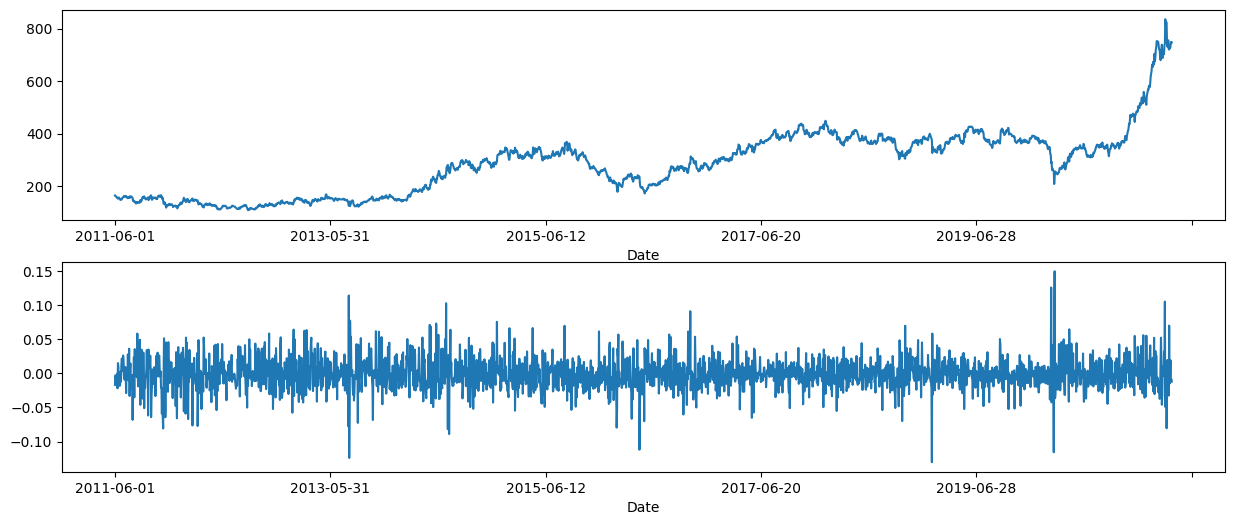

In [20]:
# plot close and factor_daily
fig, ax = plt.subplots(2,1, figsize=(15,6))
df['Close'].plot(ax=ax[0])
df['factor_daily'].plot(ax=ax[1])

**We can observe that the overall average of intraday returns is negative, with a proportion greater than 0 at 46%**

In [27]:
# count factor_daily > 0
print(df['factor_daily'].describe())
print(f"Proportion greater than 0 : {df[df['factor_daily'] > 0].shape[0] / df.shape[0] * 100}")

count    2455.000000
mean       -0.000815
std         0.022965
min        -0.130284
25%        -0.013609
50%        -0.001485
75%         0.010760
max         0.149798
Name: factor_daily, dtype: float64
Proportion greater than 0 : 46.435845213849284


## Next, let's proceed to construct our model

In [23]:
# split data into train and test sets
split_weight = 0.2
test_size = int(len(df) * split_weight)
test_ind = len(df) - test_size
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

# scale the data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train.drop('factor_daily', axis=1))
scaled_test = scaler.transform(test.drop('factor_daily', axis=1))

# generate features and labels
feature = [col for col in df.columns if col != 'factor_daily']
# X_train = np.delete(scaled_train, 19, axis=1)
# X_test = np.delete(scaled_test, 19, axis=1)
X_train = scaled_train
X_test = scaled_test
y_train = train['factor_daily'].values
y_test = test['factor_daily'].values

# time series generator
length = 60
batch_size = 64
train_gen = TimeseriesGenerator(X_train, y_train, length=length, batch_size=batch_size)
test_gen = TimeseriesGenerator(X_test, y_test, length=length, batch_size=batch_size)


In [24]:
# build LSTM model
model = Sequential()
model.add(LSTM(50, activation='sigmoid',return_sequences=True , input_shape=[length, len(feature)]))
model.add(LSTM(25, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse')

# train the model
es = EarlyStopping(monitor='val_loss', patience=20)
model.fit(train_gen, validation_data=test_gen, epochs=200, verbose=0, callbacks=[es])

<Axes: >

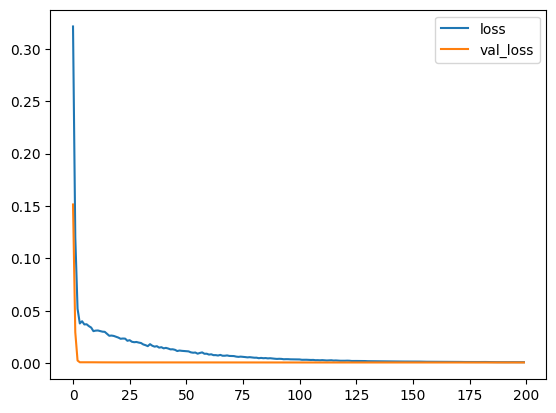

In [25]:
pd.DataFrame(model.history.history).plot()

**Let's examine the variance between the predicted and actual trends.**

RMSE: 0.13247384169272083


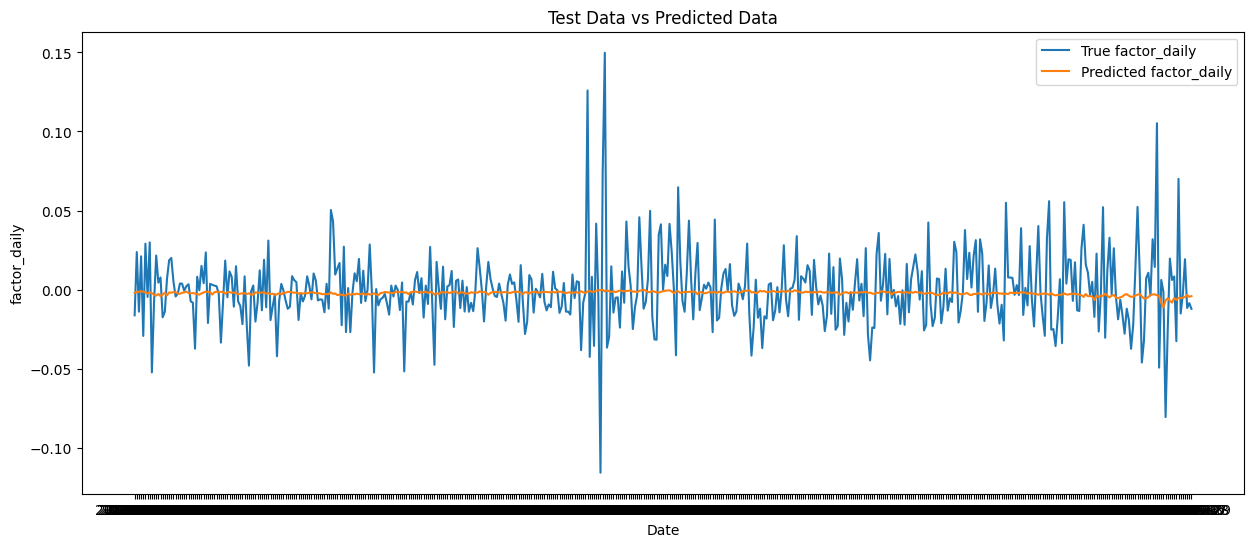

In [29]:
# make predictions
test_pred = []
current_batch = X_train[-length:].reshape(1,length, len(feature))
for i in range(len(test)):
    current_pred = model.predict(current_batch, verbose=0)[0]
    test_pred.append(current_pred)
    new_row = X_test[i]
    current_batch = np.append(current_batch[:, 1:, :], [[new_row]], axis=1)
# temp_scaler = MinMaxScaler()
# temp_scaler.fit(train[['factor_daily']])
# true_pred = temp_scaler.inverse_transform(np.array(test_pred).reshape(-1,1))
true_pred_df = pd.DataFrame(test_pred, columns=['factor_daily Prediction'], index=test.index)

# plot the result
plt.figure(figsize=(15, 6))
plt.plot(test.index, test['factor_daily'], label='True factor_daily')
plt.plot(test.index, true_pred_df['factor_daily Prediction'], label='Predicted factor_daily')
plt.legend()
plt.title('Test Data vs Predicted Data')
plt.xlabel('Date')
plt.ylabel('factor_daily')
print(f"RMSE: {np.sqrt(mean_squared_error(test['factor_daily'], true_pred))}")

**The performance in predicting intraday returns appears to be quite unsatisfactory, with no instances of returns exceeding zero**

In [30]:
pd.concat([true_pred_df,test['factor_daily']], axis=1)

,factor_daily Prediction,factor_daily
Date,,
2019-05-08,-0.002002,-0.016221
2019-05-09,-0.001346,0.023770
2019-05-10,-0.001395,-0.013923
2019-05-13,-0.000989,0.021080
2019-05-14,-0.001325,-0.029245
...,...,...
2021-04-23,-0.005024,-0.003070
2021-04-26,-0.004645,0.019252
2021-04-27,-0.003440,-0.011589


In [32]:
true_pred_df[true_pred_df['factor_daily Prediction'] > 0]

,factor_daily Prediction
Date,


## Let's attempt daily stock change.

In [83]:
df['Close_Close'] = df['Close'].shift(-2) / df['Close'].shift(-1) - 1
df['Open_t+1'] = df['Open'].shift(-1)
df = df.dropna()

In [84]:
# split data into train and test sets
split_weight = 0.2
test_size = int(len(df) * split_weight)
test_ind = len(df) - test_size
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

# scale the data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

# generate features and labels
feature = [col for col in df.columns if col != 'Close_Close']
X_train = np.delete(scaled_train, 12, axis=1)
X_test = np.delete(scaled_test, 12, axis=1)
y_train = scaled_train[:,12]
y_test = scaled_test[:,12]

# time series generator
length = 60
batch_size = 64
train_gen = TimeseriesGenerator(X_train, y_train, length=length, batch_size=batch_size)
test_gen = TimeseriesGenerator(X_test, y_test, length=length, batch_size=batch_size)


In [85]:
# build LSTM model
model = Sequential()
model.add(LSTM(50, activation='sigmoid',return_sequences=True , input_shape=[length, len(feature)]))
model.add(LSTM(25, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse')

# train the model
es = EarlyStopping(monitor='val_loss', patience=20)
model.fit(train_gen, validation_data=test_gen, epochs=200, verbose=0, callbacks=[es])

<Axes: >

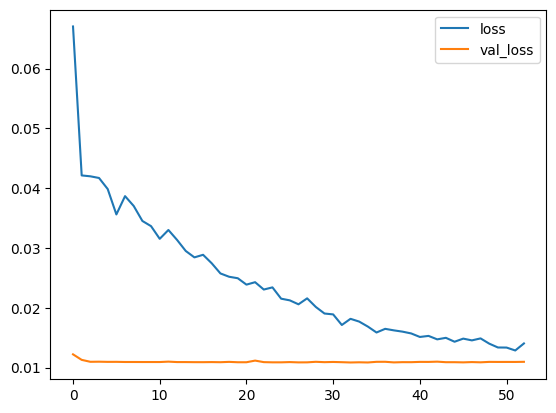

In [86]:
pd.DataFrame(model.history.history).plot()

**The result still worse.**

RMSE: 0.02584412438215624


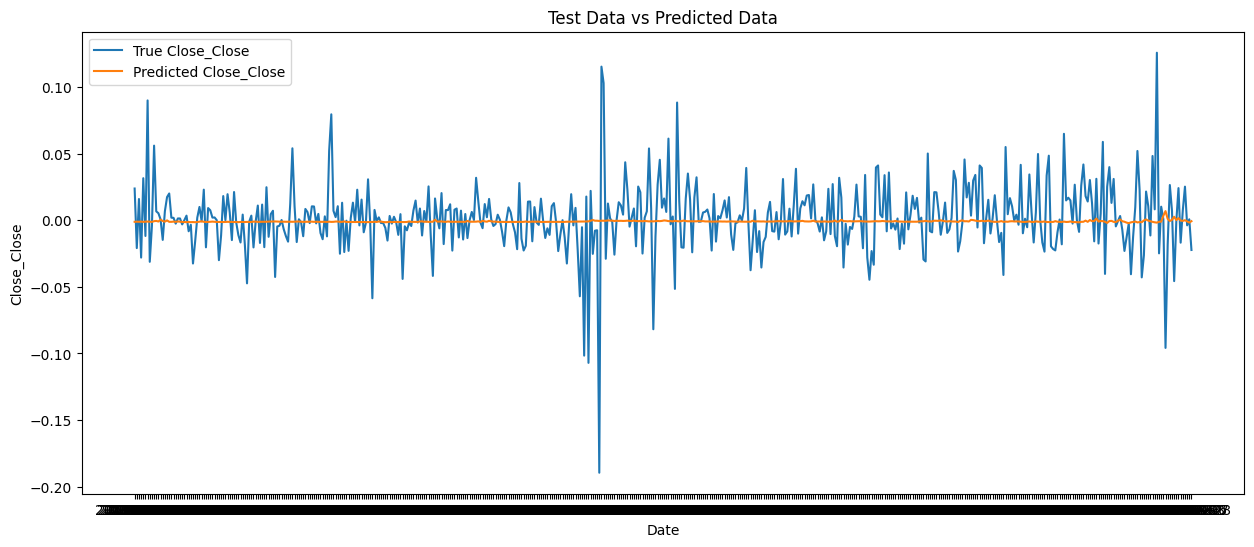

In [87]:
# make predictions
test_pred = []
current_batch = X_train[-length:].reshape(1,length, len(feature))
for i in range(len(test)):
    current_pred = model.predict(current_batch, verbose=0)[0]
    test_pred.append(current_pred)
    new_row = X_test[i]
    current_batch = np.append(current_batch[:, 1:, :], [[new_row]], axis=1)
temp_scaler = MinMaxScaler()
temp_scaler.fit(train[['Close_Close']])
true_pred = temp_scaler.inverse_transform(np.array(test_pred).reshape(-1,1))
true_pred_df = pd.DataFrame(true_pred, columns=['Close_Close Prediction'], index=test.index)

# plot the result
plt.figure(figsize=(15, 6))
plt.plot(test.index, test['Close_Close'], label='True Close_Close')
plt.plot(test.index, true_pred_df['Close_Close Prediction'], label='Predicted Close_Close')
plt.legend()
plt.title('Test Data vs Predicted Data')
plt.xlabel('Date')
plt.ylabel('Close_Close')
print(f"RMSE: {np.sqrt(mean_squared_error(test['Close_Close'], true_pred))}")

In [88]:
pd.concat([true_pred_df,test['Close_Close']], axis=1)

,Close_Close Prediction,Close_Close
Date,,
2019-05-08,-0.001214,0.023770
2019-05-09,-0.001116,-0.020937
2019-05-10,-0.001185,0.015901
2019-05-13,-0.001090,-0.028066
2019-05-14,-0.001262,0.031515
...,...,...
2021-04-22,-0.000529,0.007445
2021-04-23,0.000006,0.025180
2021-04-26,-0.000887,-0.003871


## Let's attempt predict Close Price

In [90]:
# split data into train and test sets
split_weight = 0.2
test_size = int(len(df) * split_weight)
test_ind = len(df) - test_size
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

# scale the data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

# generate features and labels
feature = [col for col in df.columns if col != 'Close']
X_train = np.delete(scaled_train, 5, axis=1)
X_test = np.delete(scaled_test, 5, axis=1)
y_train = scaled_train[:,5]
y_test = scaled_test[:,5]

# time series generator
length = 60
batch_size = 64
train_gen = TimeseriesGenerator(X_train, y_train, length=length, batch_size=batch_size)
test_gen = TimeseriesGenerator(X_test, y_test, length=length, batch_size=batch_size)


In [91]:
# build LSTM model
model = Sequential()
model.add(LSTM(50, activation='sigmoid',return_sequences=True , input_shape=[length, len(feature)]))
model.add(LSTM(25, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse')

# train the model
es = EarlyStopping(monitor='val_loss', patience=20)
model.fit(train_gen, validation_data=test_gen, epochs=200, verbose=0, callbacks=[es])

<Axes: >

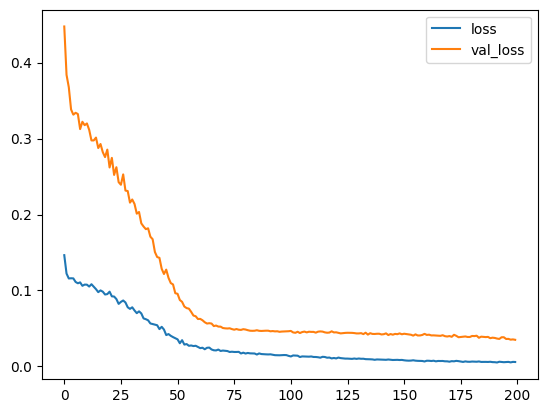

In [92]:
pd.DataFrame(model.history.history).plot()

RMSE: 59.93430569585156


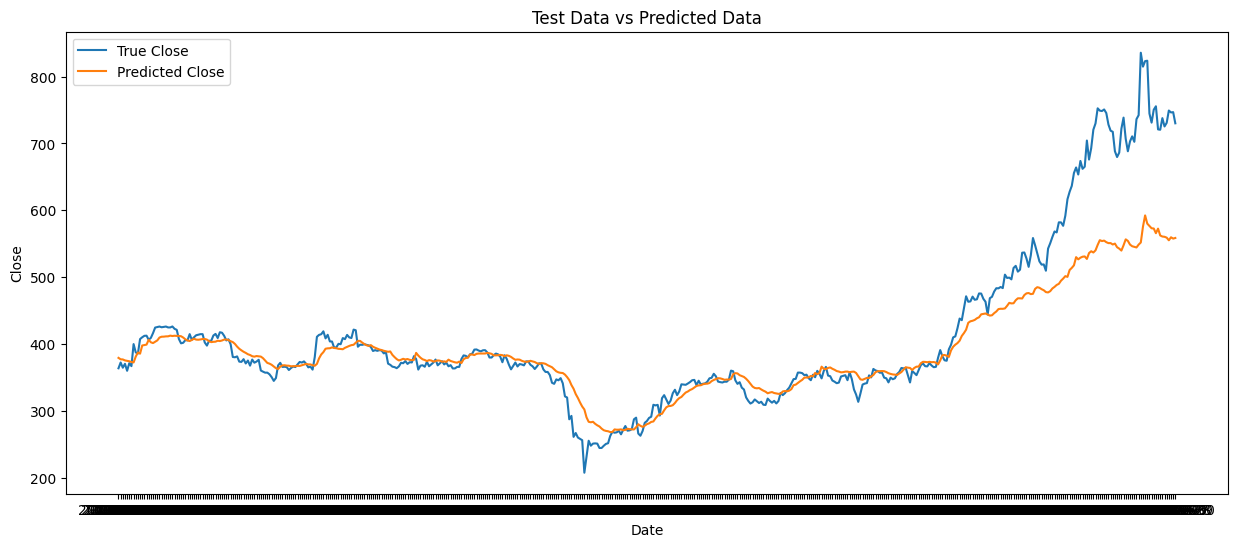

In [93]:
# make predictions
test_pred = []
current_batch = X_train[-length:].reshape(1,length, len(feature))
for i in range(len(test)):
    current_pred = model.predict(current_batch, verbose=0)[0]
    test_pred.append(current_pred)
    new_row = X_test[i]
    current_batch = np.append(current_batch[:, 1:, :], [[new_row]], axis=1)
temp_scaler = MinMaxScaler()
temp_scaler.fit(train[['Close']])
true_pred = temp_scaler.inverse_transform(np.array(test_pred).reshape(-1,1))
true_pred_df = pd.DataFrame(true_pred, columns=['Close Prediction'], index=test.index)

# plot the result
plt.figure(figsize=(15, 6))
plt.plot(test.index, test['Close'], label='True Close')
plt.plot(test.index, true_pred_df['Close Prediction'], label='Predicted Close')
plt.legend()
plt.title('Test Data vs Predicted Data')
plt.xlabel('Date')
plt.ylabel('Close')
print(f"RMSE: {np.sqrt(mean_squared_error(test['Close'], true_pred))}")

**We can establish a straightforward strategy. The strategy dictates that when the predicted closing price for the next day is higher than the current day's closing price, we will buy at the opening price the next day. Conversely, we will not trade if the prediction indicates a lower price. I am aware that this strategy does not yield profits even if predictions are correct, but let's execute it to see the outcome.**

As expected, this strategy indeed does not generate profits. It experiences significant drawdowns, and the profits continuously diminish.

In [94]:
# build out strategy
capital = 1000000
daily_returns = []
trading_days = []
ret = pd.DataFrame(index=test.index)

for i in range(1, len(true_pred)):
    if true_pred[i] > test['Close'].iloc[i-1]:
        trading_days.append(test.index[i])
        buy = int(capital // (test['Open'].iloc[i] * 1000)) 
        profit = test['Close'].iloc[i] - test['Open'].iloc[i]
        total_profit = profit * buy * 1000
        
        # calculate daily return and update daily_returns
        daily_return = total_profit / capital
        capital += total_profit
        daily_returns.append(daily_return)

# create dataframe and merge ret
target_ret = pd.DataFrame(daily_returns, index=trading_days, columns=['daily_return'])
ret = pd.merge(ret, target_ret, left_index=True, right_index=True, how='left').fillna(0)

# calculate cumulative sum for single and compound return
ret['daily_return_after_fee'] = ret['daily_return'] - (2 * 0.001425 * 0.28) - 0.003 
ret['daily_return_cumsum'] = ret['daily_return_after_fee'].cumsum()
ret['daily_return_cumprod'] = (1 + ret['daily_return_after_fee']).cumprod() - 1

# Calculate maximum drawdown
ret['daily_return_cumprod_dd'] = [(ret['daily_return_cumprod'] + 1)[i]/(ret['daily_return_cumprod'] + 1)[:i].max() - 1 for i in range(len(ret))]
        
# calculate metrics
single_period_return = ret['daily_return_cumsum'].iloc[-1]
compound_return = ret['daily_return_cumprod'].iloc[-1]
max_drawdown = ret['daily_return_cumprod_dd'].min()

print(single_period_return)
print(compound_return)
print(max_drawdown)

-1.9503449252596852
-0.8648670304838623
-0.8662483979265969


<Axes: xlabel='Date'>

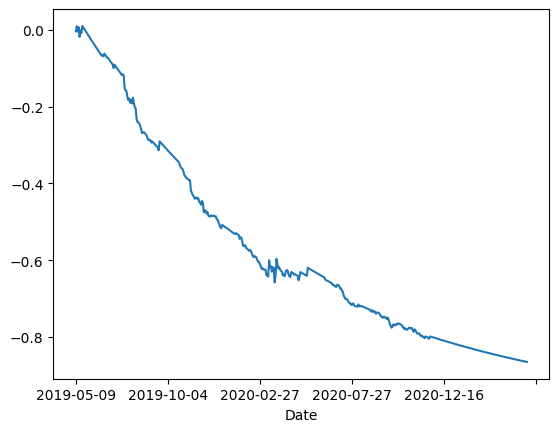

In [95]:
ret['daily_return_cumprod'].plot()

**Conclusion: Stock market prediction involves numerous variables, including the inherent randomness of the market and a wide range of features. Consequently, it's challenging for limited data to capture all the variations accurately.**